In [388]:
#!pip install numpy pandas matplotlib seaborn nltk textblob wordcloud scikit-learn tensorflow imbalanced-learn

Ensure that all of the required packages are installed.

## Importing Libraries 

Import all necessary libraries and packages.

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from imblearn.over_sampling import RandomOverSampler
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import string
from collections import Counter
from textblob import TextBlob
import warnings
import math
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

warnings.simplefilter('ignore', category=Warning, lineno=0, append=False)

# 1. Business Understanding

## 1.1. Problem: 

__Analyze customer reviews and sentiment data to categorize them as positive, negative, or neutral, providing insights for businesses to improve customer satisfaction.__

It has become difficult for the quickly expanding bookshop to keep track of and evaluate the growing number of customer evaluations for their books. The bookshop is aware of how critical it is to comprehend client sentiment in order to enhance marketing tactics, book selection, and general  satisfaction with customers. However with their growing catalogue and client base, it is time-consuming and ineffective to manually evaluate and analyse every review. Their goal is to create an automated sentiment analysis tool that can effectively classify customer evaluations into three categories: neutral, negative, and positive. Through the use of this tool, the bookshop will be able to determine what kinds of books its customers enjoy and find out what they don't and adjust its marketing and stocking strategies appropriately. Their goals are to improve customer satisfaction, keep their competitive edge in the ever-changing book industry, and expedite operations by automating the review analysis process. This business problem is in agreement with the bookstore's requirement to use data analytics to handle consumer feedback and promote expansion. They will be able to use data to their advantage and improve customer service by creating an automated sentiment analysis tool.

## 1.2. Collect and Clean Data:

### 1.2.1. Load Data

Load the data from our text file.

In [336]:
data = pd.read_csv('../data/all_kindle_review.csv', index_col='Unnamed: 0')
data.head()

,Unnamed: 0.1,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
Unnamed: 0,,,,,,,,,,
11539,0,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
5957,1,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
9146,2,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
7038,3,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
1776,4,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


In [ ]:
data.drop(columns=["Unnamed: 0.1"])

In [337]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 11539 to 11398
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    12000 non-null  int64 
 1   asin            12000 non-null  object
 2   helpful         12000 non-null  object
 3   rating          12000 non-null  int64 
 4   reviewText      12000 non-null  object
 5   reviewTime      12000 non-null  object
 6   reviewerID      12000 non-null  object
 7   reviewerName    11962 non-null  object
 8   summary         11998 non-null  object
 9   unixReviewTime  12000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 1.0+ MB


__Data Set__

- `reviewerName`: Name or identifier of the reviewer
- `overall`: Overall Rating that has been given by the reviewer (Scale of 1 to 5)
- `reviewText`: Content of the review
- `reviewTime`: Time when the review was posted
- `day_diff`: Number of days since the post was posted
- `helpful_yes`: Number of users that have found the review helpful
- `helpful_no`: Number of user that have not founf the review helpful
- `total_vote`: Total amount of votes both helpful ot unhelpful




__NULL Values__

In [338]:
print_null = lambda: print("column null values" + "\n" + "="*25 + "\n" + str(data.isnull().sum()))
print_null()

column null values
Unnamed: 0.1       0
asin               0
helpful            0
rating             0
reviewText         0
reviewTime         0
reviewerID         0
reviewerName      38
summary            2
unixReviewTime     0
dtype: int64


The primary data we want to look at is the `reviewText` if the field is missing, the data is useless, for that reason we will drop the rows with missing data.

In [339]:
data = data.dropna(subset=['reviewText'])

What does the ratings look like, what are the range of score, and is it restricted to integers, or does the user have the flexibilty to make it whatever they want?

In [341]:
data['rating'].value_counts()

rating
5    3000
4    3000
3    2000
2    2000
1    2000
Name: count, dtype: int64

The ratings is scaled from 1 to 5 and are integer values

In [342]:
data.rating = data.rating.astype(int)

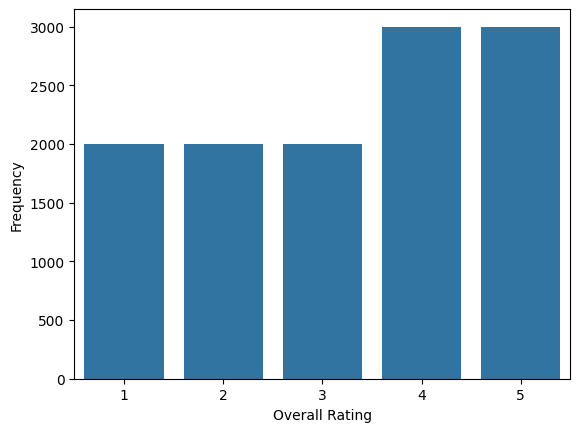

In [343]:
sns.countplot(data=data, x='rating') 
plt.ylabel('Frequency')
plt.xlabel('Overall Rating')
plt.show()

Data is relatively evenly distributed and we won't need to worry about over/under sampling.

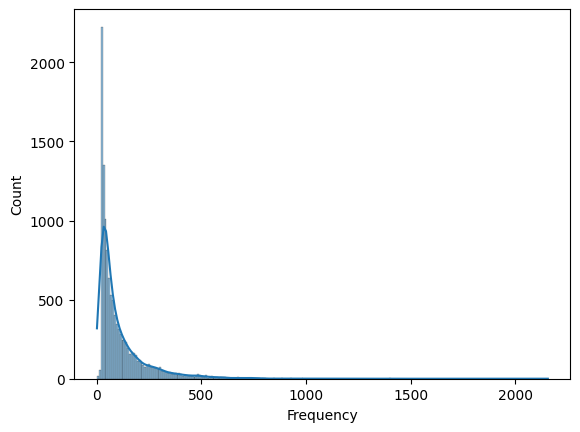

In [344]:
sns.histplot(x=data.reviewText.apply(lambda text: len(text.split(" "))), kde=True)
plt.xlabel('Word Count')
plt.xlabel('Frequency')
plt.show()

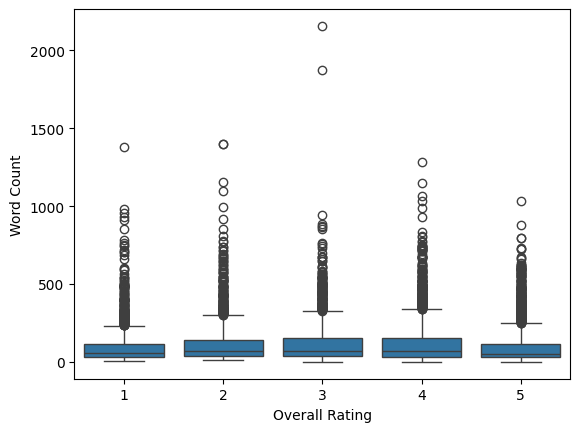

In [346]:
sns.boxplot(x=data.rating, y=data.reviewText.apply(lambda text: len(text.split(" "))))
plt.ylabel('Word Count')
plt.xlabel('Overall Rating')
plt.show()

### 1.2.2. Clean Data

#### Lowercase Text

In [347]:
lowercase = lambda text: text.lower()

#### Punctuation Removal

In [348]:
replace_apostrophe = lambda text: re.sub(r"'", '', text)
replace_punctuation = lambda text: re.sub(rf'[{string.punctuation}]', ' ', text)
remove_excess_spaces = lambda text: re.sub(rf'[{string.punctuation}]', ' ', text).strip()

### 1.3. Preprocess/Transform Data

#### Tokenize the Data

In [349]:
tokenize_sentence = lambda sentence: nltk.word_tokenize(sentence)

#### Stop Words Removal

In [350]:
remove_stopwords = lambda tokenized_sentence: [word for word in tokenized_sentence if word not in set(stopwords.words('english'))]

#### Remove Rare Words 

In [351]:
remove_rare_words = lambda tokenized_sentence, word_counts: [word for word in tokenized_sentence if word not in word_counts[word_counts <= 1]]

#### Lemmatization 

In [352]:
lemamatize_words = lambda tokenized_sentence: [WordNetLemmatizer().lemmatize(word) for word in tokenized_sentence]

#### Stemmatization

In [353]:
stem_text = lambda tokenized_sentence: [PorterStemmer().stem(word) for word in tokenized_sentence]

__PRINT IS PRETTY :3__

In [354]:
print_center = lambda text, chars, char: f' {str(text)} '.center(chars, char)
print_padding = lambda text, chars, char: str(' '*chars) + '\n' + str(print_center(text, chars, char)) + '\n' + str(' '*chars)
print_border_bottom = lambda text, chars, char: str(text) + '\n' +  str(char*chars)
print_border_top = lambda text, chars, char: str(text) + '\n' +  str(char*chars)

In [355]:
clean_text = lambda text: remove_excess_spaces(replace_punctuation(replace_apostrophe(lowercase(text))))

#=================================================================================================================================

def transform_text(data):
    chars = 150
    print(print_border_bottom(print_border_bottom(print_center('EXAMPLE TRANSFORMATION', chars, '~'), chars, '|'), chars, ' '))
    print(print_padding(data[1], chars, ' '))
    
    print(print_border_bottom(print_center('CLEANING TEXT...', chars, '~'), chars, "-"))
    data = data.apply(clean_text)
    print(print_padding(data[1], chars, ' '))

    print(print_border_bottom(print_center('TOKENIZING...', chars, '~'), chars, "-"))
    data = data.apply(tokenize_sentence)
    print(print_padding(data[1], chars, ' '))

    print(print_border_bottom(print_center('REMOVING STOPWORDS...', chars, '~'), chars, "-"))
    data = data.apply(remove_stopwords)
    print(print_padding(data[1], chars, ' '))

    print(print_border_bottom(print_center('REMOVING RARE WORDS...', chars, '~'), chars, "-"))
    word_counts = pd.Series([word for sentence in data for word in sentence]).value_counts()
    data = data.apply(lambda tokenized_sentence: remove_rare_words(tokenized_sentence, word_counts))
    print(print_padding(data[1], chars, ' '))

    print(print_border_bottom(print_center('LEMAMATIZING WORDS...', chars, '~'), chars, "-"))
    data = data.apply(lemamatize_words)
    print(print_padding(data[1], chars, ' '))

    return data

In [356]:
get_vocabulary = lambda tokenized_sentences: set([word for text in tokenized_sentences for word in text])

In [357]:
lemmatized_data = data.copy()
lemmatized_data.reviewText = transform_text(lemmatized_data.reviewText)
lemmatized_data.head(5).reviewText

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ EXAMPLE TRANSFORMATION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                                                                                                                                                      
                                                                                                                                                      
 This book is a reissue of an old one; the author was born in 1910. It's of the era of, say, Nero Wolfe. The introduction was quite interesting, explaining who the author was and why he's been forgotten; I'd never heard of him.The language is a little dated at times, like calling a gun a &#34;heater.&#34;  I also made good use of my Fire's dictionary to look up words like &#34;deshabille&#34; 

Unnamed: 0
11539    [jace, rankin, may, short, he, nothing, mess, ...
5957     [great, short, read, didnt, want, put, read, o...
9146     [ill, start, saying, first, four, book, wasnt,...
7038     [aggie, angela, carry, instead, writing, light...
1776     [expect, type, book, library, pleased, find, p...
Name: reviewText, dtype: object

# 2. Machine Learning Model Implementation

## 2.1. Explore and visualise the data 

In [360]:
vocabulary = get_vocabulary(lemmatized_data.reviewText)

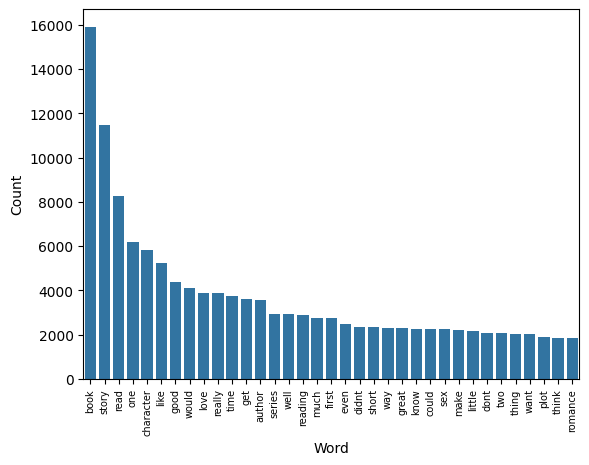

In [361]:
word_counts = pd.Series([word for sentence in lemmatized_data.reviewText for word in sentence]).value_counts().sort_values(ascending=False)
sns.barplot(x=word_counts[:35].keys(), y=word_counts[:35].values)
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Word")
plt.ylabel("Count")
plt.show()

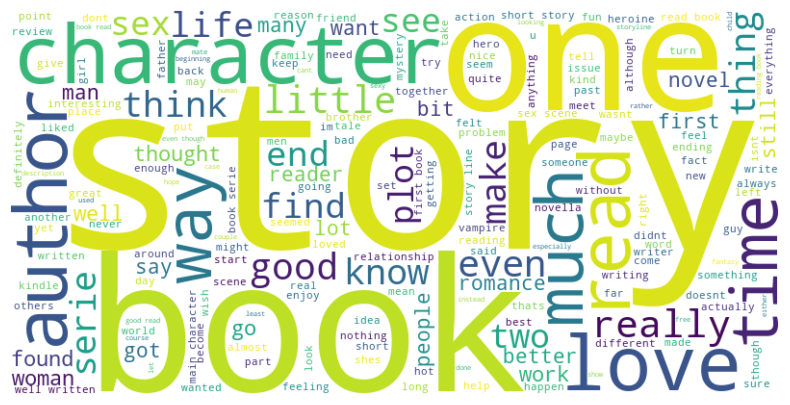

In [362]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join([word for sentence in lemmatized_data.reviewText for word in sentence]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

__Save Processed Data__ \
The computation is expensive and time consuming

In [364]:
lemmatized_data.to_csv('../data/processed_data.csv')

In [365]:
lemmatized_data['reviewText'] = lemmatized_data['reviewText'].apply(lambda x: ' '.join(x))
lemmatized_data['reviewText'].head(10)

Unnamed: 0
11539    jace rankin may short he nothing mess man salo...
5957     great short read didnt want put read one sitti...
9146     ill start saying first four book wasnt expecti...
7038     aggie angela carry instead writing light murde...
1776     expect type book library pleased find price right
3744     aislinn little girl big dream death older brot...
13641    making good story unfortunately disappoints te...
4448     got like collaborated short story alot time tw...
2797     loved book hooked series hope kelsey maxwell r...
5294     thats good thing short sweet tease give everyt...
Name: reviewText, dtype: object

## Sentiment Analyser

In [366]:
sia = SentimentIntensityAnalyzer()
lemmatized_data['sentiment'] = lemmatized_data['reviewText'].apply(lambda x: sia.polarity_scores(x)['compound'])
lemmatized_data['sentiment'].head(10)

Unnamed: 0
11539    0.9547
5957     0.9600
9146     0.7650
7038     0.1531
1776     0.4404
3744     0.9974
13641   -0.6124
4448     0.9837
2797     0.7783
5294     0.5574
Name: sentiment, dtype: float64

In [367]:
lemmatized_data['sentiment'] = lemmatized_data['sentiment'].apply(lambda x: 'positive' if x>0 else ( 'neutral' if x== 0 else 'negative'))
lemmatized_data['sentiment'].head(10)

Unnamed: 0
11539    positive
5957     positive
9146     positive
7038     positive
1776     positive
3744     positive
13641    negative
4448     positive
2797     positive
5294     positive
Name: sentiment, dtype: object

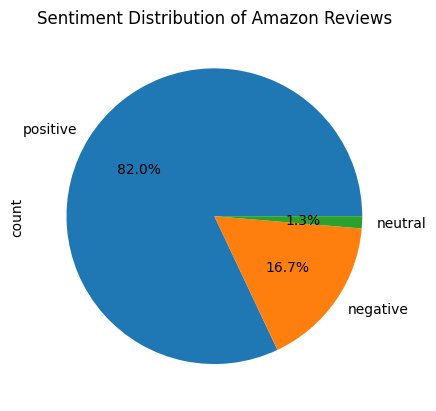

In [368]:
sentiment = lemmatized_data['sentiment'].value_counts()
sentiment.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Distribution of Amazon Reviews')
plt.show()

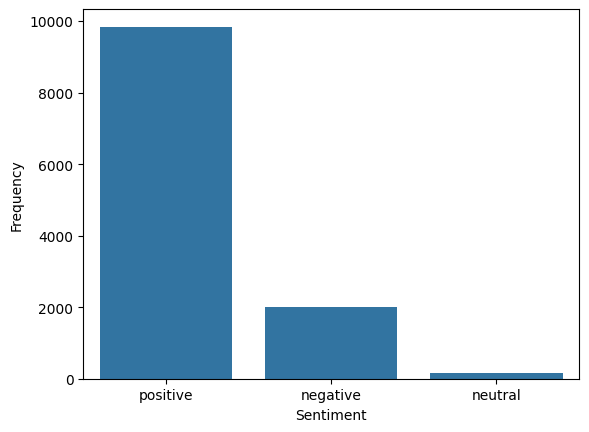

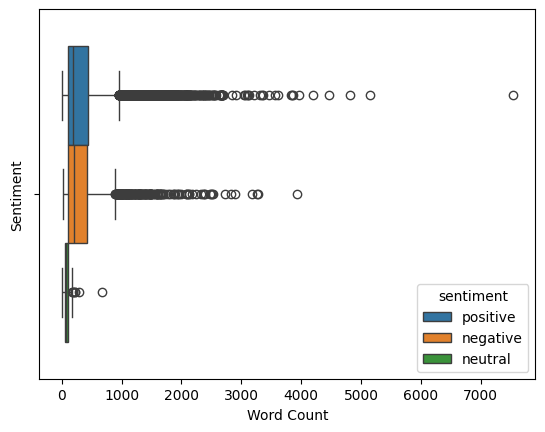

In [369]:
sns.countplot(data=lemmatized_data, x='sentiment') 
plt.ylabel('Frequency')
plt.xlabel('Sentiment')
plt.show()

sns.boxplot(x=lemmatized_data.reviewText.apply(lambda text: len(text)), hue=lemmatized_data['sentiment'])
plt.ylabel('Sentiment')
plt.xlabel('Word Count')
plt.show()

### POSITIVE WORDS

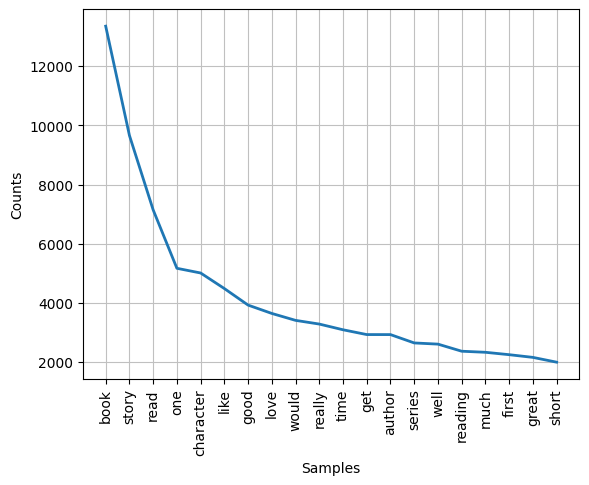

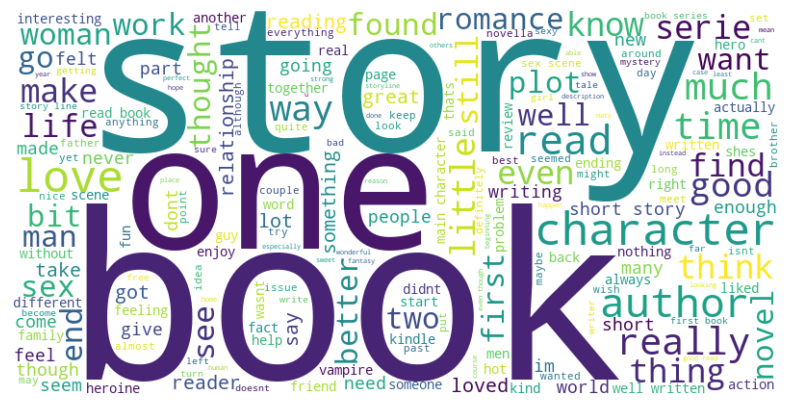

In [374]:
positive_data = lemmatized_data[lemmatized_data['sentiment'] == 'positive']
positive_distribution = nltk.FreqDist(token for tokens in positive_data["reviewText"] for token in tokens.split(" "))
positive_distribution.plot(20)
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join([word for sentence in positive_data.reviewText for word in sentence.split(" ")]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### NEUTRAL WORDS

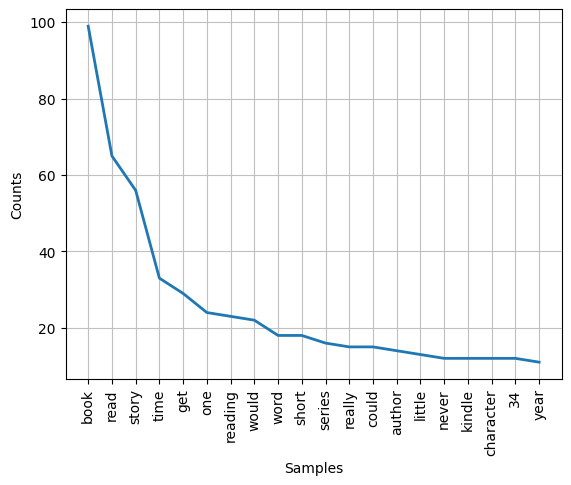

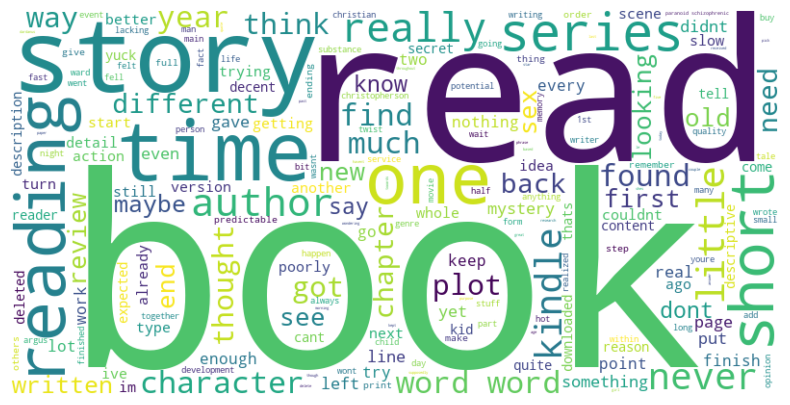

In [375]:
neutral_data = lemmatized_data[lemmatized_data['sentiment'] == 'neutral']
neutral_distribution = nltk.FreqDist(token for tokens in neutral_data["reviewText"] for token in tokens.split(" "))
neutral_distribution.plot(20)
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join([word for sentence in neutral_data.reviewText for word in sentence.split(" ")]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### NEGATIVE WORDS

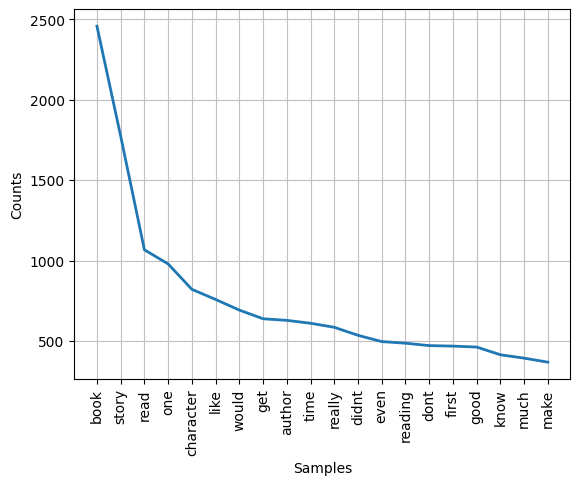

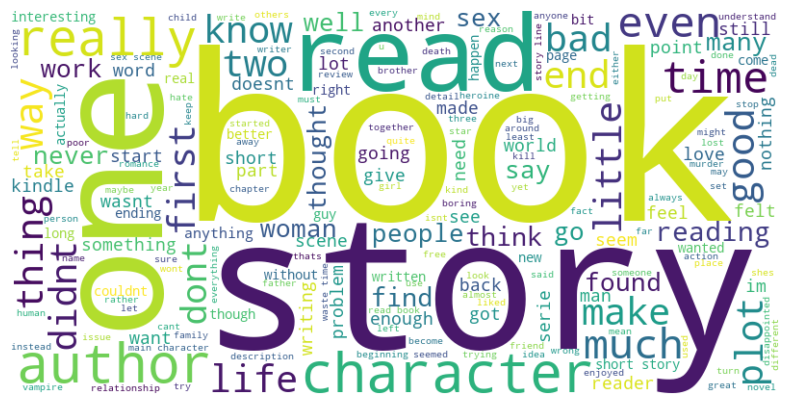

In [376]:
negative_data = lemmatized_data[lemmatized_data['sentiment'] == 'negative']
negative_distribution = nltk.FreqDist(token for tokens in negative_data["reviewText"] for token in tokens.split(" "))
negative_distribution.plot(20)
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join([word for sentence in negative_data.reviewText for word in sentence.split(" ")]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 2.2. Develop Machine Learning Model

In [377]:
vectorizer = CountVectorizer()
label_encoder = LabelEncoder()
X = vectorizer.fit_transform(lemmatized_data['reviewText'])
y = np.where(lemmatized_data['rating'] > 3, 'positive', np.where(data['rating'] == 3, 'neutral', 'negative'))

In [378]:
print("Sentiment Intensity Analyzer Accuracy: ", accuracy_score(y, lemmatized_data['sentiment']))

Sentiment Intensity Analyzer Accuracy:  0.5688333333333333


In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [380]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

## 2.2. Evaluate and Refine model

### 2.2.1. Evaluation

In [381]:
y_pred = model.predict(X_test)

In [382]:
pd.Series(y_pred).value_counts()

positive    1023
negative     861
neutral      516
Name: count, dtype: int64

<Axes: ylabel='Count'>

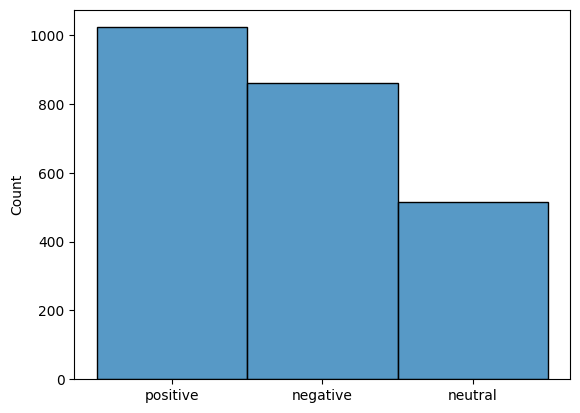

In [383]:
sns.histplot(y_pred)

Naive Bayes Accuracy: 0.6879166666666666
Classification report:               precision    recall  f1-score   support

    negative       0.71      0.78      0.74       784
     neutral       0.34      0.41      0.37       428
    positive       0.84      0.73      0.78      1188

    accuracy                           0.69      2400
   macro avg       0.63      0.64      0.63      2400
weighted avg       0.71      0.69      0.70      2400

Confusion matrix: [[612 117  55]
 [147 176 105]
 [102 223 863]]


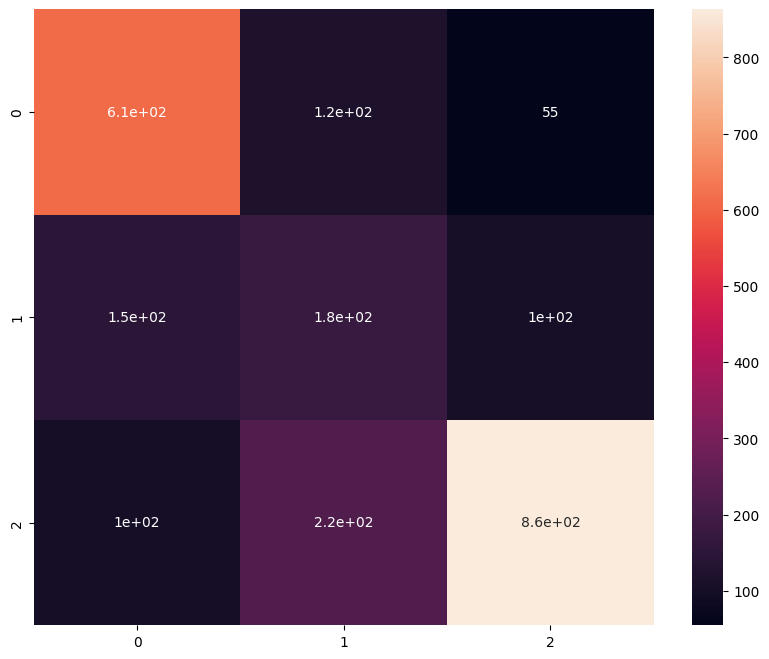

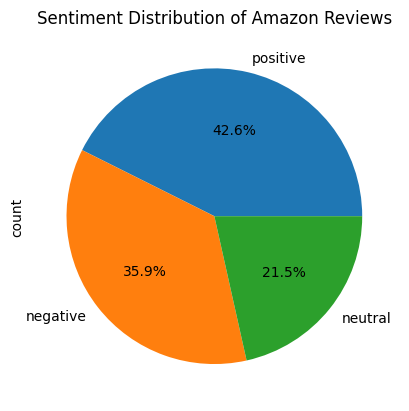

In [384]:
print('Naive Bayes Accuracy:', accuracy_score(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()
sentiment = pd.Series(y_pred).value_counts()
sentiment.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Distribution of Amazon Reviews')
plt.show()

### 2.2.2 Alternative Approach

__Random Forest Classifier__ Ensemble

In [385]:
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=1)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Naive Bayes Accuracy:', accuracy_score(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))

Naive Bayes Accuracy: 0.7145833333333333
Classification report:               precision    recall  f1-score   support

           0       0.71      0.73      0.72       787
           1       0.75      0.02      0.04       395
           2       0.72      0.93      0.81      1218

    accuracy                           0.71      2400
   macro avg       0.73      0.56      0.52      2400
weighted avg       0.72      0.71      0.65      2400

Confusion matrix: [[ 572    2  213]
 [ 147    9  239]
 [  83    1 1134]]


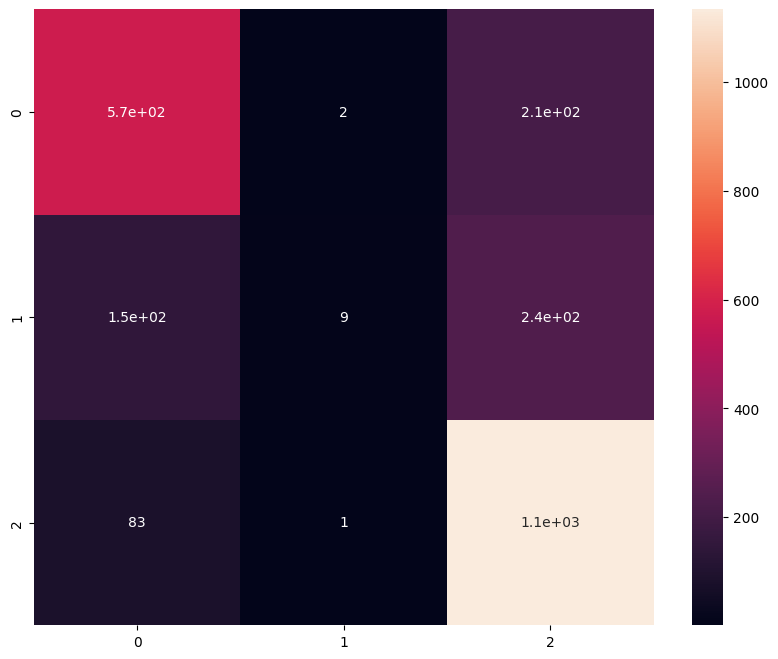

In [387]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

In [ ]:
import numpy as np
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    lemmatized_data['reviewText'], y, test_size=0.2, random_state=42
)

# Define a pipeline with a text vectorizer and a classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())  # Change this to the classifier you want to use
])

# Parameters for grid search (example for logistic regression)
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],  # Unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'clf__C': [0.1, 1.0, 10.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found:")
print(grid_search.best_params_)
print("Best cross-validation score:")
print(grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set accuracy:")
print(accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))
